<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [12]</a>'.</span>

In [1]:
# | code-summary: code -- load dependencies and data and select parameters

from compmemlearn.fitting import generate_objective_function
from compmemlearn.datasets import events_metadata, simulate_df, generate_trial_mask
from scipy.optimize import differential_evolution
from numba.typed import List, Dict
from numba.core import types
from numba import njit
from psifr import fr
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import importlib
import os

lb = np.finfo(float).eps
ub = 1 - np.finfo(float).eps

figure_caption = """Distribution of log-likelihood scores of recall sequences exhibited by each subject in dataset under each considered model."""

section_tag = "LohnasCondition1"

data_path = "../data/LohnasKahana2014.csv"
results_path = "results/"
trial_query = "condition == 1"

model_paths = ["compmemlearn.models.Classic_CMR", "compmemlearn.models.Instance_CMR", "compmemlearn.models.Dual_Instance_CMR"]

model_names = ["PrototypeCMR", "InstanceCMR", "Dual Memory ICMR"]

free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        #    'choice_sensitivity',
        "context_sensitivity",
        #    'feature_sensitivity'
        "delay_drift_rate",
    ],
]

bounds = [
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
    [
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, ub],
        [lb, 100],
        [lb, 100],
        [lb, ub],
        [lb, 10],
        [lb, 10],
        [lb, ub],
    ],
]

fixed_parameters = [
    {'sampling_rule': 0, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0}, 
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
    {"choice_sensitivity": 1, "feature_sensitivity": 1, 'mfc_familiarity_scale': 0, 
         'mcf_familiarity_scale': 0, 'drift_familiarity_scale': 0},
]

analysis_paths = ['compmemlearn.analyses.plot_spc', 'compmemlearn.analyses.plot_crp', 'compmemlearn.analyses.plot_pfr']
analysis_names = ['spc', 'crp', 'pfr']

experiment_count = 100


In [2]:
# Parameters
data_path = "data/Murdock1962.csv"
trial_query = "`list length` != 20"
model_paths = [
    "compmemlearn.models.Base_CMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
    "compmemlearn.models.Single_ICMR",
]
model_names = ["PrototypeCMR", "ICMR_1_0_0", "ICMR_1_0_1", "ICMR_1_1_0", "ICMR_1_1_1"]
free_parameters = [
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "choice_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
    [
        "encoding_drift_rate",
        "start_drift_rate",
        "recall_drift_rate",
        "shared_support",
        "item_support",
        "learning_rate",
        "primacy_scale",
        "primacy_decay",
        "stop_probability_scale",
        "stop_probability_growth",
        "context_sensitivity",
        "delay_drift_rate",
    ],
]
bounds = [
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
    [
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 100],
        [2.220446049250313e-16, 0.9999999999999998],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 10],
        [2.220446049250313e-16, 0.9999999999999998],
    ],
]
fixed_parameters = [
    {},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "context_sensitivity": 1, "learn_first": True},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": False},
    {"feature_sensitivity": 1, "choice_sensitivity": 1, "learn_first": True},
]
section_tag = "Murdock1962_NOT_LL20"


In [3]:
#| code-summary: code -- test that specified parameters are valid
#| output: false

events = pd.read_csv(data_path)

trials, list_lengths, presentations = events_metadata(events)
trial_mask = generate_trial_mask(events, trial_query)

# import models from specified source
models = []
for i in range(len(model_paths)):
    module_name, model_name = model_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    models.append(getattr(module, model_name))

# import analyses from specified source
analyses = []
for i in range(len(analysis_paths)):
    module_name, analysis_name = analysis_paths[i].rsplit('.',1) #TODO: add handling for case with no `.`
    module = importlib.import_module(module_name)
    analyses.append(getattr(module, analysis_name))

# make sure model initializes with provided parameters and boundaries
for model_index, model_class in enumerate(models):

    @njit(fastmath=True, nogil=True)
    def init_model(item_count, presentation_count, parameters):
        return model_class(item_count, presentation_count, parameters)

    subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {pd.unique(events.subject)[0]}'), trial_mask)

    cost_function = generate_objective_function(
        [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
        [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
        list_lengths,
        init_model,
        fixed_parameters[model_index],
        free_parameters[model_index],
    )
    print(cost_function)
    
    for boundary_index in range(2):
        x = np.array([each[boundary_index] for each in bounds[model_index]])
        assert(len(x) == len(free_parameters[model_index])) 

        # parameter configuration
        parameters = Dict.empty(key_type=types.unicode_type, value_type=types.float64)
        for name, value in fixed_parameters[model_index].items():
            parameters[name] = value
        for i in range(len(free_parameters[model_index])):
                parameters[free_parameters[model_index][i]] = x[i]

        model = init_model(20, 20, parameters)
        model.experience(model.items)
        model.free_recall()

        print(cost_function(x))
print('dependencies and parameters validated')
#print(trial_index, recall_index, recall, trial, likelihood[trial_index, recall_index], model.outcome_probabilities())

<function murdock_objective_function.<locals>.objective_function at 0x2b5e2c7d89d0>


9475.030215986342
14906.94041311001


<function murdock_objective_function.<locals>.objective_function at 0x2b5e2e483e50>


9475.030215986342
14906.94041311001
<function murdock_objective_function.<locals>.objective_function at 0x2b5e2e1610d0>


9475.030215986342
14906.94041311001
<function murdock_objective_function.<locals>.objective_function at 0x2b5e2d3413a0>


9475.030215986342
14906.94041311001
<function murdock_objective_function.<locals>.objective_function at 0x2b5e2e7791f0>


9475.030215986342
14906.94041311001
dependencies and parameters validated


In [4]:
# | code-summary: code -- 1) fit each model class participant-by-participant
# | output: false

for model_index, model_class in enumerate(models):

    # load individual fits for this model and section tag from csv if they exist
    if os.path.isfile(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])):
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]))
        print('individual fits for {} with tag {} already exist'.format(model_names[model_index], section_tag))

    # otherwise, fit each participant individually
    else:
        model_individual_fits = []

        @njit(fastmath=True, nogil=True)
        def init_model(item_count, presentation_count, parameters):
            return model_class(item_count, presentation_count, parameters)

        for subject in pd.unique(events.subject):
            print(f'{model_names[model_index]}, Subject {subject}')

            subject_specific_trial_mask = np.logical_and(
                generate_trial_mask(events, f'subject == {subject}'), trial_mask)
            
            try:
                # cost function to be minimized
                # ours scales inversely with the probability that the data could have been
                # generated using the specified parameters and our model
                cost_function = generate_objective_function(
                    [trials[i][subject_specific_trial_mask[i]] for i in range(len(trials))],
                    [presentations[i][subject_specific_trial_mask[i]] for i in range(len(presentations))],
                    list_lengths,
                    init_model,
                    fixed_parameters[model_index],
                    free_parameters[model_index],
                )
            except ValueError:
                continue

            fit_result =  differential_evolution(cost_function, bounds[model_index], disp=False)

            fitted_parameters = {
                'subject': subject, 'trial_count': np.sum(subject_specific_trial_mask), 
                'likelihood': fit_result.fun, 'model': model_names[model_index]
                }
            for i in range(len(fit_result.x)):
                fitted_parameters[free_parameters[model_index][i]] = fit_result.x[i]
            for key in fixed_parameters[model_index]:
                fitted_parameters[key] = fixed_parameters[model_index][key]

            model_individual_fits.append(pd.DataFrame.from_dict(fitted_parameters, orient='index').T)
            print(model_individual_fits[-1]['likelihood'][0])

        model_individual_fits = pd.concat(model_individual_fits, ignore_index=True)
        model_individual_fits.to_csv(
            results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index]), index=False)

individual fits for PrototypeCMR with tag Murdock1962_NOT_LL20 already exist
ICMR_1_0_0, Subject 1


3035.0909724432186
ICMR_1_0_0, Subject 2


4194.35890728158
ICMR_1_0_0, Subject 3


4021.0871720648665
ICMR_1_0_0, Subject 4


3770.1424164401005
ICMR_1_0_0, Subject 5


4266.086239364263
ICMR_1_0_0, Subject 6


4167.668283744427
ICMR_1_0_0, Subject 7


3702.5044858235215
ICMR_1_0_0, Subject 8


3311.0724976796305
ICMR_1_0_0, Subject 9


2940.1579969301692
ICMR_1_0_0, Subject 10


3823.453134155706
ICMR_1_0_0, Subject 11


3513.726897698465
ICMR_1_0_0, Subject 12


4011.6844789501656
ICMR_1_0_0, Subject 13


4433.42106254538
ICMR_1_0_0, Subject 14


4571.751004696905
ICMR_1_0_0, Subject 15


4232.500611265539


ICMR_1_0_1, Subject 1


3035.506105252365
ICMR_1_0_1, Subject 2


4192.632512627097
ICMR_1_0_1, Subject 3


4021.0244317149873
ICMR_1_0_1, Subject 4


3783.280769028078
ICMR_1_0_1, Subject 5


4264.074722305704
ICMR_1_0_1, Subject 6


4167.786642167432
ICMR_1_0_1, Subject 7


3702.4646553710136
ICMR_1_0_1, Subject 8


3331.14429963993
ICMR_1_0_1, Subject 9


2961.3735121793666
ICMR_1_0_1, Subject 10


3824.0078471155794
ICMR_1_0_1, Subject 11


3513.5285576709557
ICMR_1_0_1, Subject 12


4012.8526485869743
ICMR_1_0_1, Subject 13


4433.612126371277
ICMR_1_0_1, Subject 14


4576.684695798039
ICMR_1_0_1, Subject 15


4232.500733662138


ICMR_1_1_0, Subject 1


3042.183324250601
ICMR_1_1_0, Subject 2


4190.8740806292335
ICMR_1_1_0, Subject 3


4039.1214159372835
ICMR_1_1_0, Subject 4


3781.387865154431
ICMR_1_1_0, Subject 5


4277.620613863578
ICMR_1_1_0, Subject 6


4183.576765581054
ICMR_1_1_0, Subject 7


3715.108579123469
ICMR_1_1_0, Subject 8


3316.6793239222934
ICMR_1_1_0, Subject 9


2968.048640515656
ICMR_1_1_0, Subject 10


3826.9046194988205
ICMR_1_1_0, Subject 11


3519.7329047908515
ICMR_1_1_0, Subject 12


4024.6622821506635
ICMR_1_1_0, Subject 13


4437.058917868675
ICMR_1_1_0, Subject 14


4562.111219480154
ICMR_1_1_0, Subject 15


4809.391550206798
ICMR_1_1_1, Subject 1


3040.929999710458
ICMR_1_1_1, Subject 2


4200.340817226522
ICMR_1_1_1, Subject 3


4042.3729490641126
ICMR_1_1_1, Subject 4


3791.70061086202
ICMR_1_1_1, Subject 5


4267.6671610021685
ICMR_1_1_1, Subject 6


4184.934718011527
ICMR_1_1_1, Subject 7


3715.0529892792683
ICMR_1_1_1, Subject 8


3345.0786652072966
ICMR_1_1_1, Subject 9


2968.0484442124944
ICMR_1_1_1, Subject 10


3831.517002593243
ICMR_1_1_1, Subject 11


3507.2303187552925
ICMR_1_1_1, Subject 12


4017.9046077586604
ICMR_1_1_1, Subject 13


4438.489659596587
ICMR_1_1_1, Subject 14


4581.659392719587
ICMR_1_1_1, Subject 15


4250.132262231431


Text(-1.9305555555555483, 0.5, 'Individual Log-Likelihood')

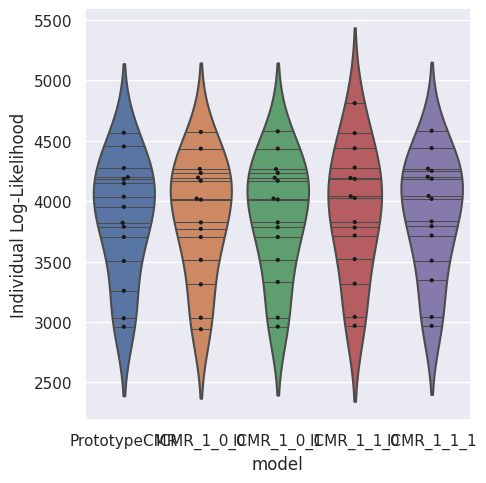

In [5]:
#| code-summary: code -- 3) plot distribution of log-likelihoods across individual subjects

plt.style.use('default')
sns.set(style="darkgrid")

# build individual fits df concatenating results from each model
individual_fits = []
for model_index, model_class in enumerate(models):
    individual_fits.append(
        pd.read_csv(results_path + '{}_{}_individual.csv'.format(section_tag, model_names[model_index])))
individual_fits = pd.concat(individual_fits, ignore_index=True)

# plot distribution of log-likelihoods across individual subjects
g = sns.catplot(x='model', y='likelihood', data=individual_fits, kind='violin', inner='stick')
sns.swarmplot(x="model", y="likelihood", data=individual_fits, color="k", size=3, ax=g.ax)
g.ax.set_ylabel('Individual Log-Likelihood')
#plt.savefig(results_path + 'individual_{}.pdf'.format(section_tag), bbox_inches="tight")

In [6]:
individual_fits

,subject,trial_count,likelihood,model,encoding_drift_rate,start_drift_rate,recall_drift_rate,shared_support,item_support,learning_rate,primacy_scale,primacy_decay,stop_probability_scale,stop_probability_growth,choice_sensitivity,delay_drift_rate,feature_sensitivity,context_sensitivity,learn_first
0,1,160,3031.022555,PrototypeCMR,0.674674,6.958903e-02,0.716534,0.123353,1.000000,0.183117,5.050809,30.562092,0.023536,0.333920,3.066932,5.286290e-10,NaN,NaN,NaN
1,2,160,4146.346282,PrototypeCMR,0.495483,3.788132e-03,0.815343,0.406046,0.861636,0.102929,4.572612,10.725792,0.008008,0.361873,7.400742,9.995899e-01,NaN,NaN,NaN
2,3,160,4036.485865,PrototypeCMR,0.718287,6.370036e-02,0.754120,0.136474,1.000000,0.130084,7.868780,7.431407,0.009972,0.348306,3.019701,3.658678e-03,NaN,NaN,NaN
3,4,160,3787.377798,PrototypeCMR,0.603496,1.080605e-03,0.869711,0.372367,0.960721,0.129742,4.992148,28.086493,0.024383,0.258183,5.534975,9.409758e-01,NaN,NaN,NaN
4,5,160,4272.908972,PrototypeCMR,0.701716,6.379364e-02,0.758005,0.111655,1.000000,0.189900,6.889114,10.600306,0.010919,0.319775,2.614713,4.445369e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70,11,160,3507.230319,ICMR_1_1_1,0.620298,2.220446e-16,0.859699,0.004313,0.755467,0.103232,55.735642,9.997503,0.020878,0.280139,1.000000,1.000000e+00,1.0,1.792825,True
71,12,160,4017.904608,ICMR_1_1_1,0.655379,2.220446e-16,0.698354,0.012149,0.873557,0.165568,29.597053,69.668161,0.011595,0.328479,1.000000,1.000000e+00,1.0,2.493414,True
72,13,160,4438.489660,ICMR_1_1_1,0.754050,2.220446e-16,0.848048,0.007031,0.820007,0.217121,22.452933,42.896266,0.008182,0.313966,1.000000,9.999790e-01,1.0,1.841021,True
73,14,160,4581.659393,ICMR_1_1_1,0.748640,2.220446e-16,0.771999,0.007036,1.000000,0.180484,19.310165,65.808774,0.006309,0.352103,1.000000,9.950174e-01,1.0,1.643619,True


In [7]:
#| code-summary: display markdown rendering of summary table
#| echo: false
#| input: false
#| output: asis

summary_table = pd.DataFrame(group.describe().rename(columns={'likelihood':name}).squeeze()
            for name, group in individual_fits[['model', 'likelihood']].groupby('model')).T.to_markdown()

print("""::: {{#fig-{section_tag}fits layout-nrow=2 layout-valign="center"}}

![]({results_path}individual_{section_tag}.pdf)

{summary_table}

{individual_fits_caption}
:::""".format(section_tag=section_tag, summary_table=summary_table, individual_fits_caption=figure_caption, results_path=results_path))

::: {#fig-Murdock1962_NOT_LL20fits layout-nrow=2 layout-valign="center"}

![](results/individual_Murdock1962_NOT_LL20.pdf)

|       |   ICMR_1_0_0 |   ICMR_1_0_1 |   ICMR_1_1_0 |   ICMR_1_1_1 |   PrototypeCMR |
|:------|-------------:|-------------:|-------------:|-------------:|---------------:|
| count |       15     |       15     |       15     |       15     |         15     |
| mean  |     3866.31  |     3870.16  |     3912.96  |     3878.87  |       3858.08  |
| std   |      491.056 |      486.744 |      536.966 |      487.752 |        490.969 |
| min   |     2940.16  |     2961.37  |     2968.05  |     2968.05  |       2960.3   |
| 25%   |     3608.12  |     3608     |     3617.42  |     3611.14  |       3603.76  |
| 50%   |     4011.68  |     4012.85  |     4024.66  |     4017.9   |       3951.91  |
| 75%   |     4213.43  |     4212.57  |     4234.25  |     4225.24  |       4190.64  |
| max   |     4571.75  |     4576.68  |     4809.39  |     4581.66  |       4565.39  |

Distr

In [8]:
#| code-summary: perform t-tests on individual-level fits
#| output: false
 
from scipy.stats import ttest_rel
import itertools

for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='two-sided'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='less'))
    print(ttest_rel(individual_fits[individual_fits.model == combination[0]].likelihood, individual_fits[individual_fits.model == combination[1]].likelihood, alternative='greater'))
    print()

('PrototypeCMR', 'ICMR_1_0_0')
Ttest_relResult(statistic=-1.1641519722719302, pvalue=0.26381832861362686)


Ttest_relResult(statistic=-1.1641519722719302, pvalue=0.13190916430681343)
Ttest_relResult(statistic=-1.1641519722719302, pvalue=0.8680908356931866)

('PrototypeCMR', 'ICMR_1_0_1')
Ttest_relResult(statistic=-1.6513512798773498, pvalue=0.12091110862921257)
Ttest_relResult(statistic=-1.6513512798773498, pvalue=0.06045555431460629)
Ttest_relResult(statistic=-1.6513512798773498, pvalue=0.9395444456853937)

('PrototypeCMR', 'ICMR_1_1_0')
Ttest_relResult(statistic=-1.3642460890730153, pvalue=0.19402043495304713)
Ttest_relResult(statistic=-1.3642460890730153, pvalue=0.09701021747652357)
Ttest_relResult(statistic=-1.3642460890730153, pvalue=0.9029897825234765)

('PrototypeCMR', 'ICMR_1_1_1')
Ttest_relResult(statistic=-2.759013474524508, pvalue=0.015370472145896043)
Ttest_relResult(statistic=-2.759013474524508, pvalue=0.0076852360729480216)
Ttest_relResult(statistic=-2.759013474524508, pvalue=0.992314763927052)

('ICMR_1_0_0', 'ICMR_1_0_1')
Ttest_relResult(statistic=-1.9297166566237454, pvalue

In [9]:
for combination in itertools.combinations(pd.unique(individual_fits.model), 2):

    print(combination)
    print(np.mean(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.mean(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print(np.sum(individual_fits[individual_fits.model == combination[0]].likelihood.values < individual_fits[individual_fits.model == combination[1]].likelihood.values), 
        np.sum(individual_fits[individual_fits.model == combination[1]].likelihood.values < individual_fits[individual_fits.model == combination[0]].likelihood.values))

    print()

('PrototypeCMR', 'ICMR_1_0_0')
0.5333333333333333 0.4666666666666667
8

 7

('PrototypeCMR', 'ICMR_1_0_1')
0.6 0.4
9 6

('PrototypeCMR', 'ICMR_1_1_0')


0.8 0.2
12 3

('PrototypeCMR', 'ICMR_1_1_1')
0.8666666666666667 0.13333333333333333
13 2

('ICMR_1_0_0', 'ICMR_1_0_1')
0.6666666666666666 0.3333333333333333
10 5

('ICMR_1_0_0', 'ICMR_1_1_0')
0.8666666666666667 0.13333333333333333
13 2

('ICMR_1_0_0', 'ICMR_1_1_1')
0.9333333333333333 0.06666666666666667
14 1

('ICMR_1_0_1', 'ICMR_1_1_0')
0.7333333333333333 0.26666666666666666
11 4

('ICMR_1_0_1', 'ICMR_1_1_1')
0.9333333333333333 0.06666666666666667
14 1

('ICMR_1_1_0', 'ICMR_1_1_1')
0.5333333333333333 0.4666666666666667
8 7



In [10]:
def model_weights(positive_log_likelihoods, number_parameters, N):
    AIC = 2 * positive_log_likelihoods + 2 * number_parameters
    AICc = AIC #+ (2*np.power(number_parameters, 2) + 2 * number_parameters) / (N - number_parameters - 2)
    AICd = AIC - np.min(AICc)
    #return AICd
    AICw = np.exp(-.5 * AICd) / np.sum(np.exp(-.5 * AICd))
    return AICw

aicw = {'Model': [], 'Subject': [], 'AICw': []}

total_nlns = np.zeros(len(models))
for subject_index, subject in enumerate(pd.unique(events.subject)):

    subject_specific_trial_mask = np.logical_and(
                    generate_trial_mask(events, f'subject == {subject}'), trial_mask)

    nlnLs = []
    for model_index, model_class in enumerate(models):
        nlnLs.append(
            individual_fits[individual_fits.model == model_names[model_index]].likelihood.values[subject_index])
    nlnLs = np.array(nlnLs)
    total_nlns += nlnLs
    
    weights = model_weights(nlnLs, len(free_parameters[model_index]), np.sum(subject_specific_trial_mask))
    #print(weights)
    for model_index, model_class in enumerate(models):
        aicw['Model'].append(model_names[model_index])
        aicw['Subject'].append(subject)
        aicw['AICw'].append(weights[model_index])

aicw = pd.DataFrame(data=aicw)
total_aicw = model_weights(total_nlns, len(free_parameters[model_index]), np.sum(trial_mask))
print(total_aicw)

[1.00000000e+000 2.40287886e-054 1.96049396e-079 0.00000000e+000
 3.80078651e-136]


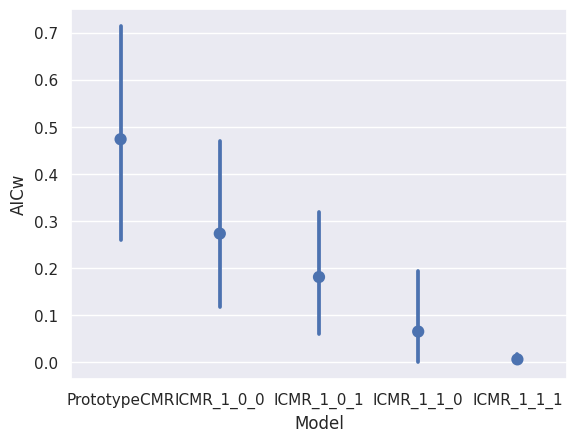

In [11]:
import seaborn as sns
sns.set_theme(style="darkgrid")
x = sns.pointplot(x="Model", y="AICw", data=aicw, join=False)

plt.show()

<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [12]:
sns.set(style='darkgrid')

# for each unique list length
if not (isinstance(list_lengths, list) or isinstance(list_lengths, List)): 
    list_lengths = [list_lengths]

for list_length in list_lengths:

    #fig, axes = plt.subplots(nrows=len(models), ncols=3, figsize=(15, int(4*len(models))), sharey=False)
    
    # for each unique model
    for model_index, model_class in enumerate(models):

        # load sim_df from csv if it exists
        sim_df_path = results_path + '{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length)
        if os.path.isfile(sim_df_path):
            sim_df = pd.read_csv(sim_df_path)
            print('sim_df for {} with tag {} and list length {} already exists'.format(model_names[model_index], section_tag, list_length))

        # otherwise, generate it
        else:

            # for each unique matching entry in individual df
            sim_dfs = []
            for subject in pd.unique(individual_fits.subject):
                
                fit_result = individual_fits.query(f'subject == {subject} & model == "{model_names[model_index]}"')

                # configure model based on specified parameters
                fitted_parameters = Dict.empty(
                    key_type=types.unicode_type, value_type=types.float64
                )
                for i in range(len(free_parameters[model_index])):
                    fitted_parameters[free_parameters[model_index][i]] = fit_result[free_parameters[model_index][i]].values[0]
                for key in fixed_parameters[model_index]:
                    fitted_parameters[key] = fixed_parameters[model_index][key]

                # simulate df based on specified trial_count and experiment_count
                #model = model_class(list_length, list_length, fitted_parameters)
                sim_dfs.append(simulate_df_from_events(model, fit_result['trial_count'].values[0] * experiment_count))
                sim_dfs[-1].list = sim_dfs[-1].subject
                sim_dfs[-1].subject = subject

            # concatenate simulations into one dataframe
            sim_df = pd.concat(sim_dfs)

            # save sim_df to csv
            sim_df.to_csv(results_path +'{}_{}_ll{}_sim_df.csv'.format(section_tag, model_names[model_index], list_length), index=False)

        # design general filter for analysis df
        if len(list_lengths) > 1:
            analysis_query = trial_query + f' & list_length == {list_length}'
        else:
            analysis_query = trial_query

        # generate plot for each parametrized analysis and model
        for analysis_index, analysis_function in enumerate(analyses):
            analysis_name = analysis_names[analysis_index]
            axis = analysis_function(
                [events, sim_df], analysis_query, contrast_name="source", labels=["data", model_names[model_index]])
            plt.savefig(results_path+'{}_{}_ll{}_{}.pdf'.format(section_tag, model_names[model_index], list_length, analysis_name), bbox_inches="tight")

NameError: name 'simulate_df_from_events' is not defined